<a href="https://colab.research.google.com/github/irlanassidiq/titanic-survival-rate-kaggle-solution/blob/main/Titanic_survival_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
import plotly.express as px

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier
import warnings

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go

train = pd.read_csv("test.csv")
test = pd.read_csv("train.csv")
df_data = pd.concat([train, test], sort=True).set_index('PassengerId')

In [4]:
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
892,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,3,male,0,NaN,330911
893,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,3,female,1,NaN,363272
894,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,2,male,0,NaN,240276
895,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,3,male,0,NaN,315154
896,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,3,female,1,NaN,3101298


1. Missing values

1.1. Tickets

dropping "Ticket" column from dataframe

In [5]:
cols_with_missing = [col for col in df_data.columns if df_data[col].isnull().any()] 
pd.isnull(df_data[cols_with_missing]).sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Survived     418
dtype: int64

In [7]:
df_data = df_data.drop(['Ticket'],axis=1)

KeyError: ignored

1.2 Age

To address the problem of missing values for the Age field we will proceed as follows. Since PClass is the variable that is most correlated with both Age and Survived, we will group passengers according to the class they belong to. What we will do is replace the missing values with the median of each group. In fact, what is more, within each of the existing classes we will make a gender distinction. We do this because, as we will see below, the median of Age varies according to whether the passenger is male or female.

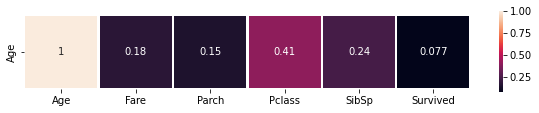

In [9]:
df_heatmap = pd.DataFrame(df_data.corr()['Age'].abs())
f,ax = plt.subplots(figsize=(10,1.5),facecolor='white')
sns.color_palette("rocket", as_cmap=True)         
sns.heatmap(df_heatmap.transpose(),annot = True,square=True, linewidths=1.5, cmap='rocket')

In [13]:
mediana = df_data.groupby(['Sex', 'Pclass']).median()['Age']
for i in range(0,mediana.shape[0]):
    if i<3: 
        print('Median age for women in the class {}: {}'.format(i+1,mediana[i]))
    else:
        print('Median age for men of the class {}: {}'.format(i+1-3,mediana[i]))
df_data.Age = df_data.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))
print('Missing values for Age: {}'.format(df_data.Age.isnull().sum()))

Median age for women in the class 1: 36.0
Median age for women in the class 2: 28.0
Median age for women in the class 3: 22.0
Median age for men of the class 1: 42.0
Median age for men of the class 2: 29.5
Median age for men of the class 3: 25.0
Missing values for Age: 0


1.3 Embarked
With respect to Embarked we will replace the missing data by the mode, i.e. the most repeated value.

In [14]:
df_data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [16]:
mode = 'S'
df_data.Embarked = df_data.Embarked.replace(np.nan,mode)
pd.isnull(df_data).sum()

Age            0
Cabin       1014
Embarked       0
Fare           1
Name           0
Parch          0
Pclass         0
Sex            0
SibSp          0
Survived     418
dtype: int64

1.4 Cabin

Cabin feature is little bit tricky and it needs further exploration. The large portion of the Cabin feature is missing and the feature itself can't be ignored completely because some the cabins might have higher survival rates. It turns out to be the first letter of the Cabin values are the decks in which the cabins are located. Those decks were mainly separated for one passenger class, but some of them were used by multiple passenger classes.

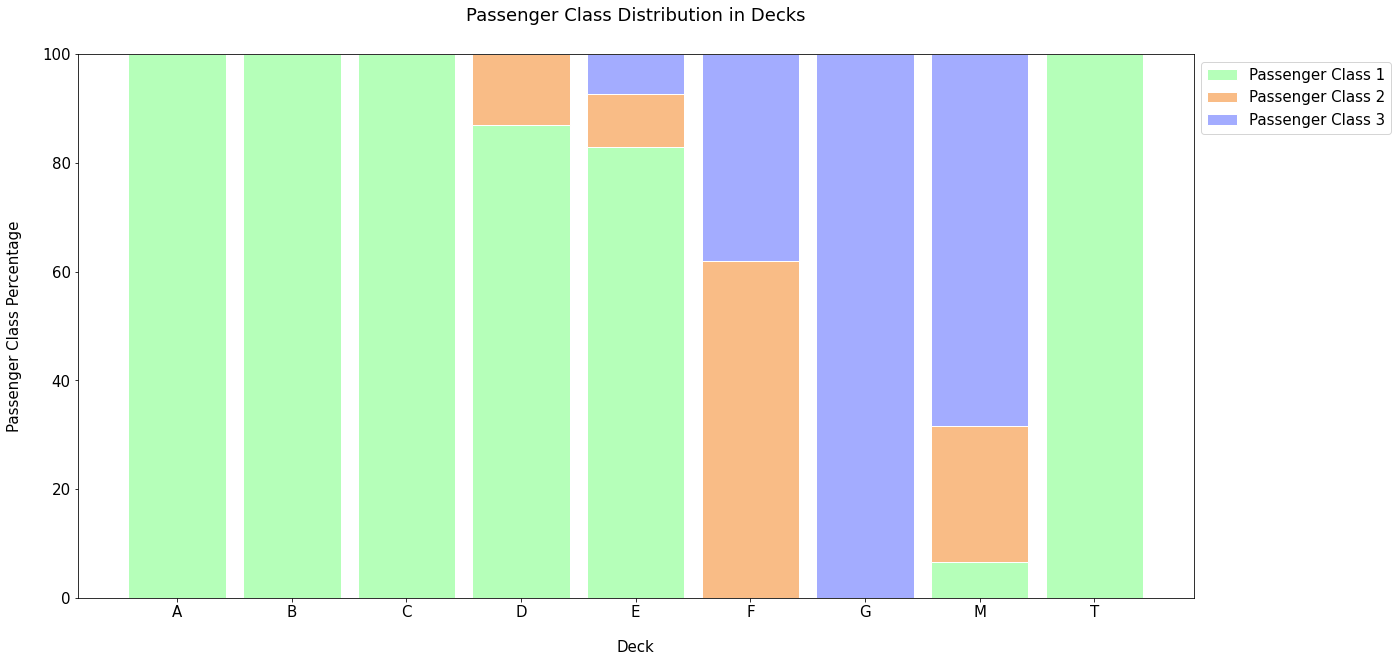

In [17]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_data['Deck'] = df_data['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_data_decks = df_data.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 
                                                                        'Fare', 'Embarked', 'Cabin']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_data_decks)
display_pclass_dist(all_deck_per)

Interpret: for this graph we'll be grouping by Deck and PClass atribute. We are able to appreciate that A,B and C are fully occupied by passengers of 1st class. Moreover, as there is just one person in deck T, which class 1 we are going to group it with deck A. Deck of type D is mainly occupied with 1st class passengers, concretely a 85%. The rest are from 2nd class. To conclude, the remaining decks have all passengers from each of the classes.

In [19]:
# Passenger in the T deck is changed to A
idx = df_data[df_data['Deck'] == 'T'].index
df_data.loc[idx, 'Deck'] = 'A'

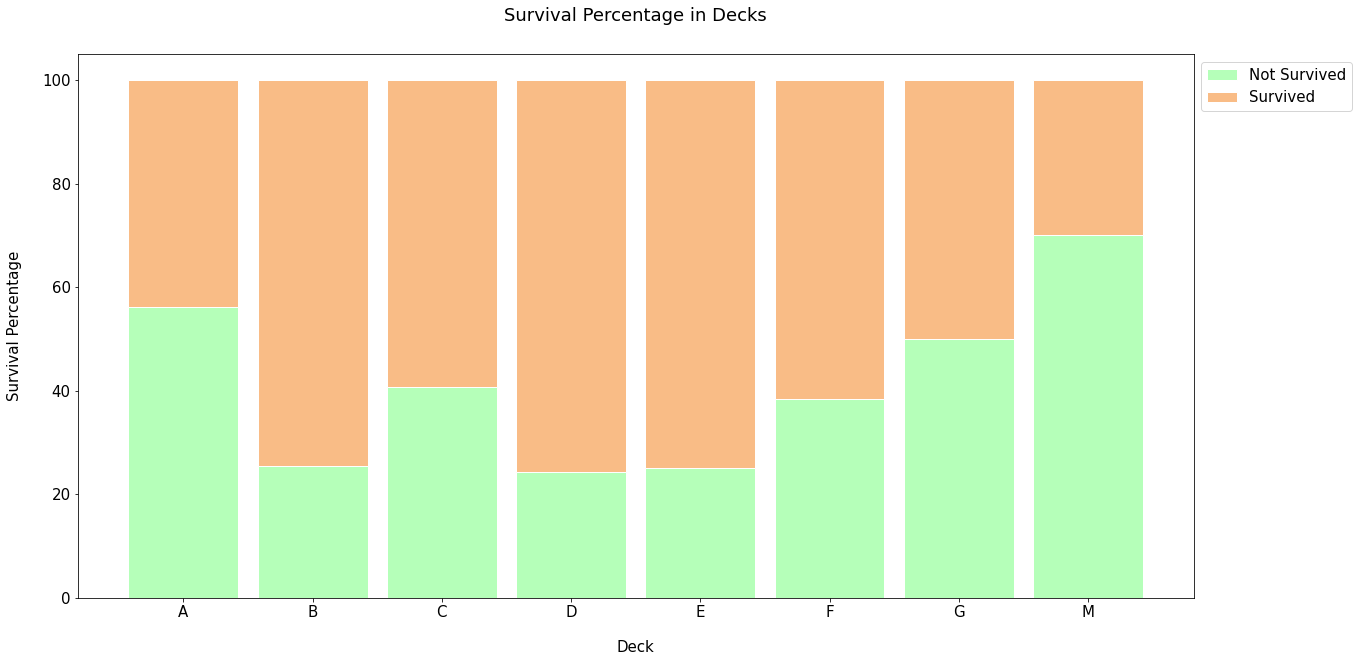

In [20]:
df_all_decks_survived = df_data.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

Interpret: for this graph we'll be grouping by Deck and Survived atribute, in order to see the survival rate that each Deck has. We are able to appreciate that as expected survival rates are different for every type of Deck. B, D and E are the ones with highest. On the other hand, A and M are the ones with lowest.

Due to what we have just seen before, we are going to label decks in the following way:

1. A, B and C decks, as they all have 1st class passengers, are going to be 
labeled as ABC
2. D and E decks are labeled as DE because both of them have similar passenger class distribution and same survival rate
3. Following the previous criterion we labeled FG
4. M remains equal because it's quite different from the others and it's the one with lowest survival rate.

In [21]:
df_data['Deck'] = df_data['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_data['Deck'] = df_data['Deck'].replace(['D', 'E'], 'DE')
df_data['Deck'] = df_data['Deck'].replace(['F', 'G'], 'FG')

df_data['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [22]:
df_data = df_data.drop('Cabin',axis=1)
df_data.isnull().sum()

Age           0
Embarked      0
Fare          1
Name          0
Parch         0
Pclass        0
Sex           0
SibSp         0
Survived    418
Deck          0
dtype: int64

1.5 Fare

We have one missing value for Fare, belonging to the test dataset. We are going to fill it with the most repeated value of this field.

In [23]:
tst = df_data[df_data.Survived.isnull() == True]
median = tst.Fare.describe()[6]
df_data.Fare = df_data.Fare.fillna(median)

2. Feature Engineering

2.1. Family

We will start by creating fields related to the family unit. The first of these will come from the SibSp and Parch fields, which we can remove later. This will reflect the size of passengers' family. We will also enter a field to indicate whether the passenger is travelling alone or not.

In [24]:
df_data['FamilySize'] = df_data.Parch + df_data.SibSp + 1
df_data['IsAlone'] = 0
df_data.loc[df_data['FamilySize'] == 1, 'IsAlone'] = 1
df_data = df_data.drop(['Parch','SibSp'],axis = 1)

2.2. Passenger's name

Next we are going to add a column that will be, in part, related to the Name field:

In [25]:
df_data.head()

,Age,Embarked,Fare,Name,Pclass,Sex,Survived,Deck,FamilySize,IsAlone
PassengerId,,,,,,,,,,
892,34.5,Q,7.8292,"Kelly, Mr. James",3,male,NaN,M,1,1
893,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",3,female,NaN,M,2,0
894,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",2,male,NaN,M,1,1
895,27.0,S,8.6625,"Wirz, Mr. Albert",3,male,NaN,M,1,1
896,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",3,female,NaN,M,3,0


In [26]:
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


We can replace many titles with a more common name or classify them as Rare.

In [27]:
df_data['Title'] = df_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df_data['Title'] = df_data['Title'].replace('Mlle', 'Miss')
df_data['Title'] = df_data['Title'].replace('Ms', 'Miss')
df_data['Title'] = df_data['Title'].replace('Mme', 'Mrs')

df_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().transpose()

,0,1,2,3,4
Title,Master,Miss,Mr,Mrs,Rare
Survived,0.575,0.702703,0.156673,0.793651,0.347826


2.3. Fare

In order to binning continuous features we are going to use 13 quantile base bins. Even though the bins are too much, they provide a decent amount of information gain, as it would be seen in next section. We'll create df_data_no_quart in order to have a DataFrame with the discrete values of Fare, to make it easier to plotting it later.

In [28]:
df_data_no_quart = df_data.copy()
names = ['1', '2', '3', '4', '5', '6', '7','8','9','10','11','12','13']
df_data['Fare'] = pd.qcut(df_data['Fare'], 13, labels = names)
df_data.Fare = pd.to_numeric(df_data.Fare, errors = 'coerce')

2.4. Age

Let's keep binning continuous features. For Age we are going to use 10 quantile base bins. Even though the bins are too much, they provide a decent amount of information gain, as it would be seen in next section.

In [29]:
names = ['1','2','3','4','5','6','7','8','9','10']
df_data['Age'] = pd.qcut(df_data['Age'], 10, labels = names)

3. Data visualization

3.1. Heat map

📌 Interpret: On the one hand, the variables with the highest correlations are: PClass and Fare. On the other hand, we can appreciate that both, Age and FamilySize are the ones with less correlation coefficient with respect to Survived.

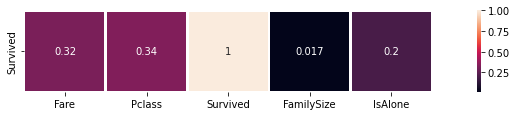

In [30]:
df_heatmap = pd.DataFrame(df_data.corr()['Survived'].abs())
f,ax = plt.subplots(figsize=(16,1.5),facecolor='white')
sns.color_palette("rocket", as_cmap=True)          # Esta paleta es la que viene por defecto
sns.heatmap(df_heatmap.transpose(),annot = True,square=True, linewidths=1.5, cmap='rocket')

3.2. Group of Age visualization

📌 Interpret: We have created several age groups, in order to make it easier to make the graphs. On the left size, we have the average fare per each group of age. As observed, older group (48-80) is the group which has payed more. At the bottom part of the bar graph we can find groups to which teenagers and young adults belong. On the right, I have made a pie plot in order to find which percentage of people from each group survive, and people from which group is more likely to survive. We can see that kids (0.169-16) are the ones with more survival rate (14.6%). Moreover, we also observe that half of the kids survived. Concretely, a 58.8% of kids survived. On the other hand, older people and youngsters between 21-22 years old bear the brunt as they are the least likely to survive. Indeed, from the whole group of old people just 34% survived aproximately.

In [31]:
#names = ['0-8', '9-15', '16-18', '19-25', '26-40', '41-60', '61-100']
oneHot_train_graph = df_data_no_quart.copy()
names = ['0.169-16','16-21','21-22','22-25','25-26','26-29.5','29.5-34','34-40','40-48','48-80']
oneHot_train_graph['Age'] = pd.qcut(oneHot_train_graph['Age'], 10, labels = names)
df_bar = oneHot_train_graph.groupby('Age').agg({'Fare':'mean'}).reset_index().sort_values(by='Fare',ascending=False).set_index('Age')
df_pie = oneHot_train_graph.groupby('Age').agg({"Survived" : "mean"}).reset_index().sort_values(by='Survived', ascending=False).set_index('Age')

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}]],                          
                    column_widths=[0.7, 0.3], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Average Fare per Group of Age", "Survival Percentage per Group of Age"))

fig.add_trace(go.Bar(x=df_bar['Fare'], y=df_bar.index, marker=dict(color=['#334550','#334550','#394184','#394184','#6D83AA','#6D83AA','#C8D0DF','#C8D0DF','#C8D0DF','#C8D0DF']),
                     name='Fare', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_pie['Survived'], labels=df_pie.index, name='Age',
                     marker=dict(colors=['#334550','#334668','#394184','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label'), 
                    row=1, col=2)
# styling
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_layout(height=500, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Group of Age Analysis",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

3.3. PClass visualization

📌 Interpret: for this graph we'll be grouping by PClass atribute. I have plotted 3 different graphs relating PClass with Title, Loneliness and Family Size. We are able to appreciate that lonely people have chosen class 3 more than any other. Indeed, both Class 3 and Class 2 have been the preference for more lonely people than accompanied. Class 1 as seen, is more likely to be chosen by people accompanied by one familiar. Families with 3 or more people on board are uniformly distributed between different classes.

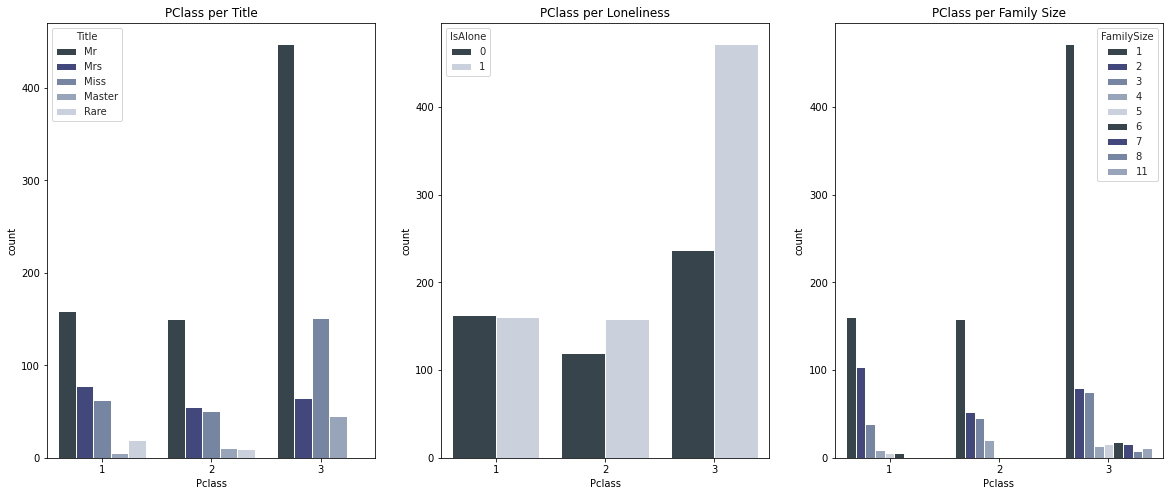

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20, 8))

sns.set_style('whitegrid')
ax = sns.countplot(x = "Pclass", hue='Title', data = df_data,ax = axes[0], palette=['#334550','#394184','#6D83AA','#91A2BF','#C8D0DF']);
ax.set_title('PClass per Title')

sns.set_style('whitegrid')
ax = sns.countplot(x = "Pclass", hue='IsAlone', data = df_data,ax = axes[1], palette=['#334550','#C8D0DF']);
_ = ax.set_title('PClass per Loneliness')

sns.set_style('whitegrid')
ax = sns.countplot(x = "Pclass", hue='FamilySize', data = df_data,ax = axes[2], palette=['#334550','#394184','#6D83AA','#91A2BF','#C8D0DF']);
__ = ax.set_title('PClass per Family Size')

3.4. Fare visualization

📌 Interpret: The groups at the left side of the graph has the lowest survival rate and the groups at the right side of the graph has the highest survival rate. This high survival rate was not visible in the distribution graph. There is also an unusual group (15.742, 23.25] in the middle with high survival rate that is captured in this process.

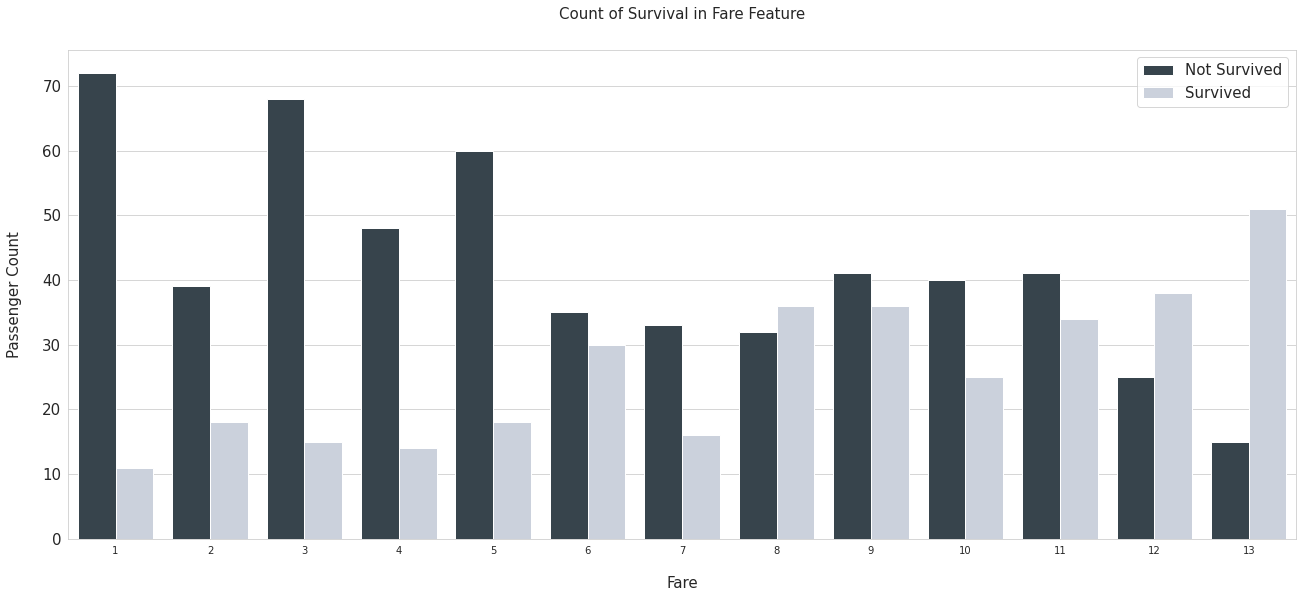

In [33]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_data, palette=['#334550','#C8D0DF'])

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

4. Categorical variables

4.1. One Hot encoding

We will now proceed with the oneHot Imputation. With this, we will change the values of the categorical variables to numerical. This technique comes in handy since both categorical variables have a small number of unique values.

In [34]:
df_data.dtypes

Age           category
Embarked        object
Fare             int64
Name            object
Pclass           int64
Sex             object
Survived       float64
Deck            object
FamilySize       int64
IsAlone          int64
Title           object
dtype: object

In [35]:
print(df_data.Embarked.unique())
print(df_data.Sex.unique())

['Q' 'S' 'C']
['male' 'female']


In [36]:
object_cols = [cname for cname in df_data.columns if df_data[cname].dtype == "object"]
object_cols

['Embarked', 'Name', 'Sex', 'Deck', 'Title']

In [37]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_data = pd.DataFrame(OH_encoder.fit_transform(df_data[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_data.index = df_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_x_data = df_data.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_data= pd.concat([num_x_data, OH_cols_data], axis=1)

In [38]:
OH_data

,Age,Fare,Pclass,Survived,FamilySize,IsAlone,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
892,8,3,3,NaN,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
893,9,1,3,NaN,2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
894,10,5,2,NaN,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
895,6,5,3,NaN,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
896,3,6,3,NaN,3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,6,6,2,0.0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
888,2,10,1,1.0,1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
889,3,9,3,0.0,4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


As we can see, columns 0 and 1 correspond to the Sex attribute, while the rest with Embarked. At this point, we have our dataset ready to be modeled.

5. Modeling

For the modeling part we will compare 10 known algorithms, and proceed to evaluate their average accuracy by a stratified kfold cross validation procedure:

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis
- XGBoost Classifier

To begin with, we are going to create a cross validate model with Kfold stratified. Then we'll test each of the algorithms that I have mentioned before.

In [39]:
x_train = OH_data[OH_data.Survived.isnull() == False].drop('Survived',axis=1)
y_train = OH_data[OH_data.Survived.isnull() == False].Survived

In [40]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state = random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LinearDiscriminantAnalysis",'XGBClassifier']})
cv_res = cv_res.sort_values(by='CrossValMeans',ascending = False)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 726, in fit
    missing=self.missing, nthread=self.n_jobs)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 380, in __init__
    feature_types)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 239, in _

In [41]:
fig = make_subplots(rows=1, cols=1, 
                    specs=[[{"type": "bar"}]])

fig.add_trace(go.Bar(x=cv_res['CrossValMeans'], y=cv_res.Algorithm, marker=dict(color=['#334550','#334550','#334668','#334668','#496595','#496595','#6D83AA','#6D83AA','#91A2BF','#C8D0DF']),
                     name='Fare', orientation='h'), 
                     row=1, col=1)
# styling
fig.update_yaxes(showgrid=True, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=True, row=1, col=1)
fig.update_layout(height=500, bargap=0.1,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text="Cross Validation Scores",
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), 
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

5.2. Hyperparameter Tuning

For the ensemble modeling we are going to use:

- ExtraTreesClassifier
- SVC
- AdaBoost
- RandomForest
- GradientBoosting 

In order to make execution quicker, we set n_jobs to -1. This means that we are going to use every CPU we have in the computer.

In [42]:
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsadaDTC.fit(x_train,y_train)
ada_best = gsadaDTC.best_estimator_

# RFC Parameters tunning 
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsRFC.fit(x_train,y_train)
RFC_best = gsRFC.best_estimator_

# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsGBC.fit(x_train,y_train)
GBC_best = gsGBC.best_estimator_

# SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}
gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsSVMC.fit(x_train,y_train)
SVMC_best = gsSVMC.best_estimator_

#ExtraTrees 
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsExtC.fit(x_train,y_train)
ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Fitting 10 folds for each of 54 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Fitting 10 folds for each of 28 candidates, totalling 280 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Fitting 10 folds for each of 54 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



5.3. Ensemble modeling and prediction

For the final part of this project I have chosen VotingClassifier. We'll fit the model and then proceed to make the predictions. At the final part of this section you'll find some graphs related to survival predictions made.

In [43]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(x_train, y_train)

In [44]:
x_test = OH_data[OH_data.Survived.isnull() == True].drop('Survived',axis=1)
mediana = x_test.Fare.describe()[6]
x_test.Fare = x_test.Fare.fillna(mediana)
predictions_survived = votingC.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning:

Feature names o

In [45]:
predictions = pd.DataFrame({'Survived' : predictions_survived},index = x_test.index)
predictions['Survived'] = predictions.Survived.astype(int)
predictions.to_csv('submission.csv')

Finally, we will graph the results obtained in order to illustrate the understanding of these results.

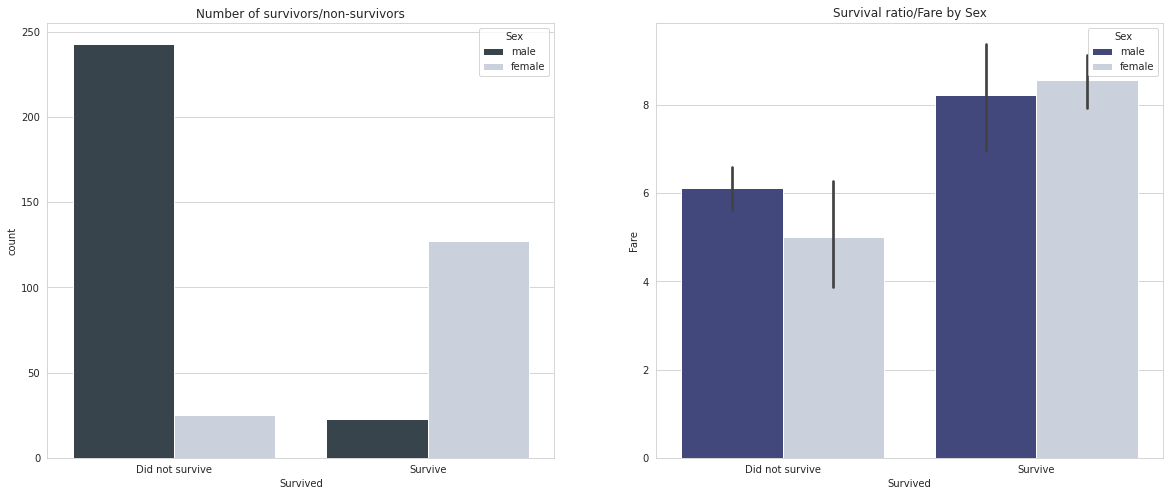

In [47]:
x_test_predicted = df_data[df_data.Survived.isnull() == True].copy()
x_test_predicted['Survived'] = predictions.Survived
df_sex_bars = pd.DataFrame({'Survived':x_test_predicted.Survived, 'Sex':x_test_predicted.Sex, 'Fare':x_test_predicted.Fare,'PClass':x_test_predicted.Pclass,'Age':x_test_predicted.Age,'IsAlone':x_test_predicted.IsAlone,'Title':x_test_predicted.Title})
df_sex_bars['Survived'].replace([0,1], ['Did not survive','Survive'], inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 8))

sns.set_style('whitegrid')
ax = sns.countplot(x = "Survived", hue='Sex', data = df_sex_bars,ax = axes[0],palette=['#334550','#C8D0DF'])
ax.set_title('Number of survivors/non-survivors')

sns.set_style('whitegrid')
ax = sns.barplot(x = "Survived", y='Fare', hue = 'Sex', data = df_sex_bars,ax = axes[1],palette=['#394184','#C8D0DF']);
_ = ax.set_title('Survival ratio/Fare by Sex')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning:

13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



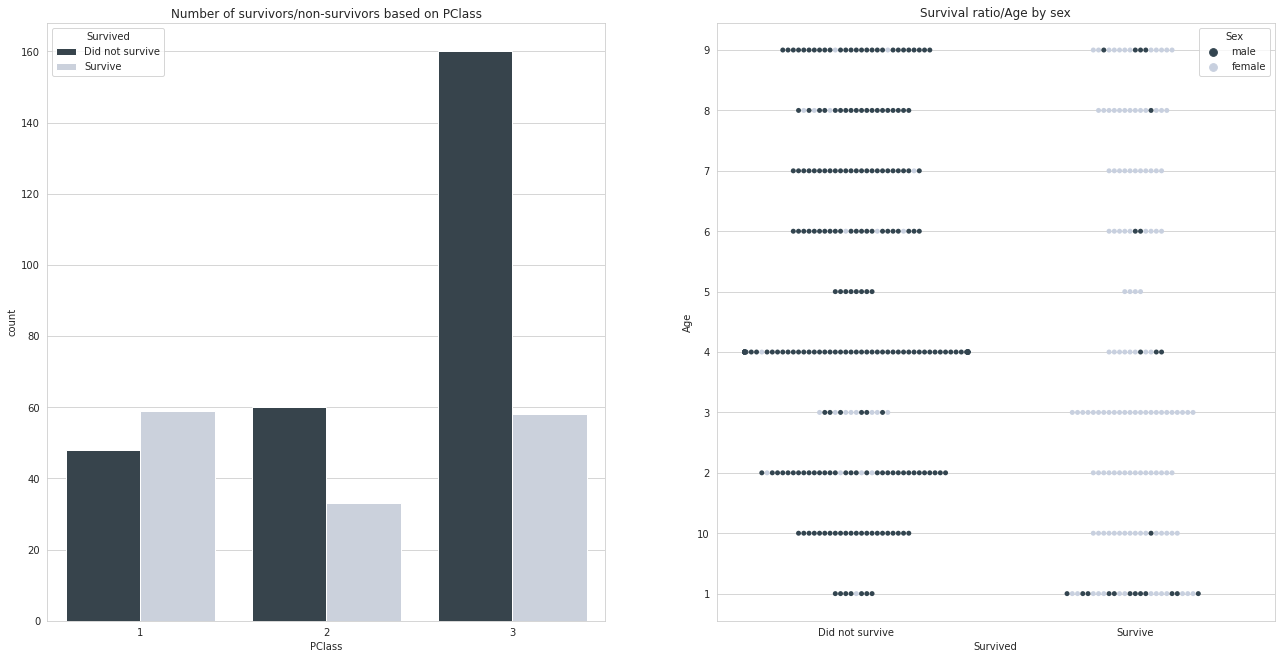

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(22, 11))

sns.set_style('whitegrid')
ax = sns.countplot(x = "PClass", hue='Survived', data = df_sex_bars,ax = axes[0],palette=['#334550','#C8D0DF']);
ax.set_title('Number of survivors/non-survivors based on PClass')

sns.set_style('whitegrid')
ax = sns.swarmplot(x = "Survived", y='Age', hue = 'Sex', data = df_sex_bars,ax = axes[1],palette=['#334550','#C8D0DF']);
_ = ax.set_title('Survival ratio/Age by sex')

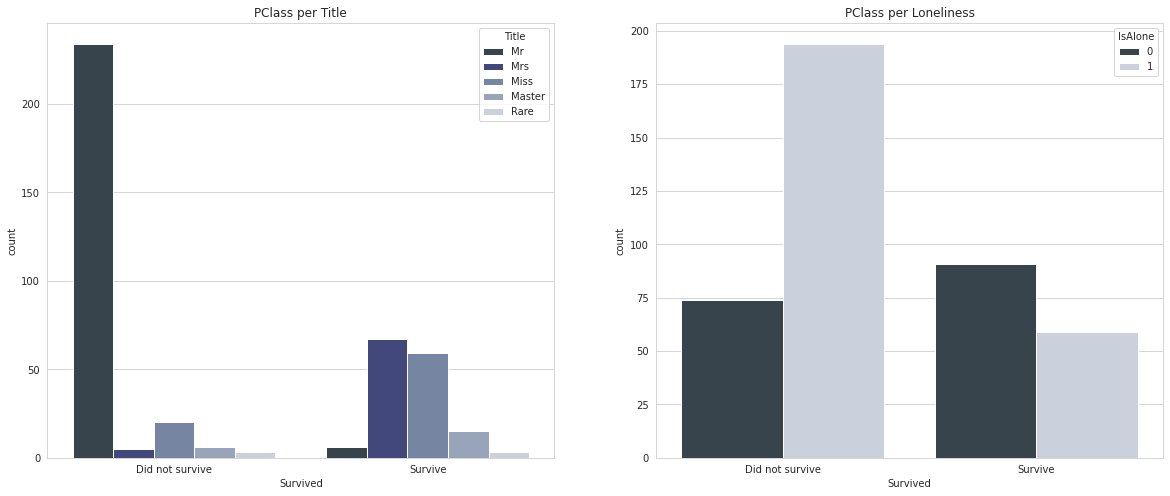

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20, 8))

sns.set_style('whitegrid')
ax = sns.countplot(x = "Survived", hue='Title', data = df_sex_bars,ax = axes[0], palette=['#334550','#394184','#6D83AA','#91A2BF','#C8D0DF']);
ax.set_title('PClass per Title')

sns.set_style('whitegrid')
ax = sns.countplot(x = "Survived", hue='IsAlone', data = df_sex_bars,ax = axes[1], palette=['#334550','#C8D0DF']);
_ = ax.set_title('PClass per Loneliness')